In [1]:
import os
import sys
import pandas as pd
import numpy as np
import time
import tables
import warnings
from datetime import date, datetime, timedelta
from pvoutput import *
from pvoutput.utils import get_logger

## TODO

* It's possible that some of the dates in the missing_dates table are not actually missing(!)  (There was a period when there was a bug in the code, where it wouldn't always pass the correct requested date to PVOutput.org's API).

In [2]:
BASE_PATH = os.path.expanduser('~/data/pvoutput.org/')

OUTPUT_TIMESERIES_FILENAME = os.path.join(BASE_PATH, 'UK_PV_timeseries.hdf')

INPUT_PV_LIST_FILENAME = os.path.join(BASE_PATH, 'UK_PV_listing_metadata.hdf')
METADATA_FILENAME = os.path.join(BASE_PATH, 'UK_PV_metadata.csv')
PV_STATS_FILENAME = os.path.join(BASE_PATH, 'UK_PV_stats.csv')

START_DATE = pd.Timestamp("2019-01-01")
END_DATE = pd.Timestamp("2019-07-01")

logger = get_logger(stream_handler=False)

In [3]:
pv_systems = pd.read_hdf(INPUT_PV_LIST_FILENAME, 'metadata')

In [4]:
pv_systems['system_capacity_kW'] = pd.to_numeric(pv_systems['system_capacity'].str.replace('kW', ''))
pv_systems.drop('system_capacity', axis='columns', inplace=True)

In [5]:
pv_systems.head()

,Array Tilt,Inverter,Location,Orientation,Panels,Shade,system_name,Outputs,Generation,Average,Efficiency,system_capacity_kw,efficiency_kWh_per_kW,system_1_tilt_degrees,system_2_tilt_degrees,system_capacity_kW
system_id,,,,,,,,,,,,,,,,
26965,11.0°,Enphase M215,United Kingdom CV47,South 0.0°,336x250W Q Cells Pro-G3 250,Low,mfl_phc,1813 days,399.238MWh,220.208kWh,2.654kWh/kW,84.00,2.654,11.0,NaN,84.00
24768,NaN,aurora trio,United Kingdom OX7,South 180.0°,1050x240W qidong,No,mfl_qfa,446 days,307.029MWh,688.405kWh,2.732kWh/kW,252.00,2.732,NaN,NaN,252.00
11542,15.0°,SMA TRI-Power 1700 TL,United Kingdom PE11,South 180.0°,200x250W Emmvee ES 230 M60 B,No,Wray Farms Solar System,2437 days,293.684MWh,120.510kWh,2.477kWh/kW,50.00,2.477,15.0,NaN,50.00
66991,40.0°,Unknown,United Kingdom HR8,South 180.0° / South West 225.0°,152x325W + 80x325W Unknown,No,Ledbury Community Hospital,1434 days,279.902MWh,195.190kWh,2.603kWh/kW,75.40,2.603,40.0,NaN,75.40
5116,15.0°,Fronius CL36; Datamanager 2.0,United Kingdom OX7,South 180.0°,182x235W Q.Base-G2 235,No,mfl_scf,2538 days,267.470MWh,105.386kWh,2.493kWh/kW,42.77,2.493,15.0,NaN,42.77


In [6]:
pv_metadata = pd.read_csv(METADATA_FILENAME, index_col='system_id')

In [7]:
pv_metadata.head()

,system_name,system_size_watts,postcode,number_of_panels,panel_power_watts,panel_brand,num_inverters,inverter_power_watts,inverter_brand,orientation,array_tilt_degrees,shade,install_date,latitude,longitude,status_interval_minutes,number_of_panels_secondary,panel_power_watts_secondary,orientation_secondary,array_tilt_degrees_secondary
system_id,,,,,,,,,,,,,,,,,,,,
19397,AndyT's,3900,BS22,20,195,ZN Shine 195w,1,3500,Kaco 4202,S,30.0,No,2011-11-21 00:00:00,51.36,-2.92,5,0,0,NaN,NaN
8195,Kilmarnock Roof,3750,KA3,15,250,Sanyo 250 HIT,1,4000,Omniksol,S,30.0,No,2011-11-07 00:00:00,55.64,-4.49,10,0,0,NaN,NaN
8200,Flat 5,3430,E8,14,245,NaN,1,3000,sb3000,S,25.0,Low,2011-12-12 00:00:00,51.54,-0.06,5,0,0,NaN,NaN
8204,Sooper-Dooper Solar,2940,GU2,12,245,SunTech STP245S-20/Wd,1,3000,Kaco Powador 3002,S,19.0,No,2012-05-11 00:00:00,51.24,-0.59,10,0,0,NaN,NaN
8205,58GPR,4000,BS48,16,250,Sanyo component Europe GmbH,1,50,Sma sunny boysb3800v,S,NaN,No,2011-11-10 00:00:00,51.42,-2.74,10,0,0,NaN,NaN


In [8]:
pv_stats = pd.read_csv(
    PV_STATS_FILENAME, 
    index_col='system_id',
    parse_dates=['actual_date_from', 'actual_date_to', 'record_efficiency_date']
)
pv_stats.head()

,energy_generated_Wh,energy_exported_Wh,average_generation_Wh,minimum_generation_Wh,maximum_generation_Wh,average_efficiency_kWh_per_kW,outputs,actual_date_from,actual_date_to,record_efficiency_kWh_per_kW,record_efficiency_date,stats_downloaded_on_utc
system_id,,,,,,,,,,,,
12290,28040596.0,0.0,10068.0,0.0,28548.0,2.543,2785.0,2011-11-30,2019-07-21,570.96,2013-05-25 00:00:00,1.563877e+18
8200,6399918.0,77311.0,7950.0,2.0,31047.0,2.388,805.0,2012-05-01,2014-10-14,620.94,2012-09-08 00:00:00,1.563877e+18
4105,12214111.0,7482325.0,9239.0,0.0,44085.0,2.924,1322.0,2011-10-11,2015-05-24,881.70,2015-03-23 00:00:00,1.563877e+18
53258,0.0,0.0,0.0,0.0,0.0,0.000,584.0,2017-07-15,2019-02-20,0.00,2019-02-20 00:00:00,1.563877e+18
8205,4313500.0,0.0,10546.0,0.0,27500.0,210.920,409.0,2011-11-11,2012-12-23,550.00,2012-05-16 00:00:00,1.563877e+18


In [9]:
pv_systems_joined = (
    pv_systems
    .join(
        pv_metadata[['status_interval_minutes', 'install_date', 'latitude', 'longitude']],
        how='left'
    ).join(
        pv_stats[['actual_date_from', 'actual_date_to', 'outputs']],
        how='left'
    ))

In [10]:
# Filter 'bad' systems
pv_systems_filtered = pv_systems_joined.query(
    'status_interval_minutes <= 60 and outputs > 100')

pv_systems_filtered = pv_systems_filtered.query(
    ' actual_date_from <= @START_DATE and'
    ' actual_date_to >= @END_DATE')

pv_systems_filtered = pv_systems_filtered.dropna(subset=['latitude', 'longitude'])

In [11]:
len(pv_systems_filtered)

829

In [12]:
pv_systems_filtered.head()

,Array Tilt,Inverter,Location,Orientation,Panels,Shade,system_name,Outputs,Generation,Average,...,system_1_tilt_degrees,system_2_tilt_degrees,system_capacity_kW,status_interval_minutes,install_date,latitude,longitude,actual_date_from,actual_date_to,outputs
system_id,,,,,,,,,,,,,,,,,,,,,
26965,11.0°,Enphase M215,United Kingdom CV47,South 0.0°,336x250W Q Cells Pro-G3 250,Low,mfl_phc,1813 days,399.238MWh,220.208kWh,...,11.0,NaN,84.00,5,2014-01-17 00:00:00,52.230000,-1.380000,2014-01-08,2019-07-23,1815.0
11542,15.0°,SMA TRI-Power 1700 TL,United Kingdom PE11,South 180.0°,200x250W Emmvee ES 230 M60 B,No,Wray Farms Solar System,2437 days,293.684MWh,120.510kWh,...,15.0,NaN,50.00,5,2011-12-08 00:00:00,52.800000,-0.160000,2012-09-12,2019-07-23,2439.0
5116,15.0°,Fronius CL36; Datamanager 2.0,United Kingdom OX7,South 180.0°,182x235W Q.Base-G2 235,No,mfl_scf,2538 days,267.470MWh,105.386kWh,...,15.0,NaN,42.77,10,2011-12-07 00:00:00,51.945568,-1.385417,2011-12-09,2019-07-23,2540.0
5701,1.0°,SMA Tripower 8000TL,United Kingdom DA1,South 180.0°,46x215W Schuco,Low,Workshop,2837 days,78.561MWh,27.692kWh,...,1.0,NaN,9.89,5,NaN,51.420000,0.110000,2011-10-15,2019-07-23,2839.0
28016,30.0°,SMA Sunny Boy 17000TL,United Kingdom CB3,South 180.0° / South East 135.0°,80x240W + 44x240W REW 240 Premium QM60,No,Robinson College,772 days,77.214MWh,100.018kWh,...,30.0,NaN,29.76,5,2013-10-10 00:00:00,52.210000,0.020000,2014-03-22,2019-07-23,774.0


In [13]:
pv_systems_filtered.sort_values('system_capacity_kW', ascending=False, inplace=True)
pv_systems_filtered.head()

,Array Tilt,Inverter,Location,Orientation,Panels,Shade,system_name,Outputs,Generation,Average,...,system_1_tilt_degrees,system_2_tilt_degrees,system_capacity_kW,status_interval_minutes,install_date,latitude,longitude,actual_date_from,actual_date_to,outputs
system_id,,,,,,,,,,,,,,,,,,,,,
26965,11.0°,Enphase M215,United Kingdom CV47,South 0.0°,336x250W Q Cells Pro-G3 250,Low,mfl_phc,1813 days,399.238MWh,220.208kWh,...,11.0,NaN,84.00,5,2014-01-17 00:00:00,52.230000,-1.380000,2014-01-08,2019-07-23,1815.0
11542,15.0°,SMA TRI-Power 1700 TL,United Kingdom PE11,South 180.0°,200x250W Emmvee ES 230 M60 B,No,Wray Farms Solar System,2437 days,293.684MWh,120.510kWh,...,15.0,NaN,50.00,5,2011-12-08 00:00:00,52.800000,-0.160000,2012-09-12,2019-07-23,2439.0
5116,15.0°,Fronius CL36; Datamanager 2.0,United Kingdom OX7,South 180.0°,182x235W Q.Base-G2 235,No,mfl_scf,2538 days,267.470MWh,105.386kWh,...,15.0,NaN,42.77,10,2011-12-07 00:00:00,51.945568,-1.385417,2011-12-09,2019-07-23,2540.0
42642,1.0°,Energy Monitor,United Kingdom HD7,North 0.0°,120x250W N/A,No,EnergyHive Dashboardz,1267 days,4.398MWh,3.471kWh,...,1.0,NaN,30.00,15,NaN,-28.278880,23.521875,2015-12-22,2019-07-23,1269.0
28016,30.0°,SMA Sunny Boy 17000TL,United Kingdom CB3,South 180.0° / South East 135.0°,80x240W + 44x240W REW 240 Premium QM60,No,Robinson College,772 days,77.214MWh,100.018kWh,...,30.0,NaN,29.76,5,2013-10-10 00:00:00,52.210000,0.020000,2014-03-22,2019-07-23,774.0


In [14]:
# Links to website for manually checking data:
# ['https://pvoutput.org/intraday.jsp?sid={}&dt=20190809'.format(sid) for sid in pv_systems_filtered.index[10:15]]

In [15]:
def hdf_key(system_id):
    return '/timeseries/{:d}'.format(system_id)

In [16]:
def safe_convert_to_date(dt):
    if isinstance(dt, pd.Timestamp):
        return dt.date()
    if isinstance(dt, date):
        return dt
    
# test
DATE_TEST = date(2019, 1, 1)
assert DATE_TEST == safe_convert_to_date(DATE_TEST)
assert DATE_TEST == safe_convert_to_date(pd.Timestamp(DATE_TEST))

In [17]:
def get_dates_already_downloaded(system_id):
    if os.path.exists(OUTPUT_TIMESERIES_FILENAME):
        with pd.HDFStore(OUTPUT_TIMESERIES_FILENAME, mode='r') as store:
            try:
                datetimes = store.select(key=hdf_key(system_id), columns=['datetime', 'query_date'])
            except KeyError:
                already_processed = set([])
            else:
                query_dates = [safe_convert_to_date(dt) for dt in datetimes['query_date'].dropna()]
                already_processed = set(datetimes.index.date).union(query_dates)
    else:
        already_processed = set([])
    return already_processed

In [18]:
def get_data_from_hdf(system_id, filename=OUTPUT_TIMESERIES_FILENAME):
    with pd.HDFStore(filename, mode='r') as store:
        data = store.select(key=str(system_id))
    return data

In [19]:
def append_missing_date(date_to_load, datetime_of_api_request, system_id):
    new_missing_date = pd.DataFrame(
        {
            'missing_date_PV_localtime': pd.Timestamp(date_to_load),
            'datetime_of_API_request': datetime_of_api_request,
        },
        index=[system_id])
    new_missing_date.index.name = 'pv_system_id'
    with pd.HDFStore(OUTPUT_TIMESERIES_FILENAME, mode='a', complevel=9) as store:
        store.append(key='missing_dates', value=new_missing_date)

In [20]:
pv = PVOutput()

In [ ]:
logger.info('\n******* STARTING UP ************')

MISSING_DATES_COLUMNS = [
    'pv_system_id', 'missing_date_PV_localtime', 'datetime_of_API_request']
# Set all_missing_dates to empty DataFrame, in case OUTPUT_TIMESERIES_FILENAME
# doesn't exist, or if it doesn't contain 'missing_dates'.
all_missing_dates = pd.DataFrame(columns=MISSING_DATES_COLUMNS)
if os.path.exists(OUTPUT_TIMESERIES_FILENAME):
    try:
        all_missing_dates = get_data_from_hdf('missing_dates')
    except KeyError:
        pass

print('Number of missing dates found so far:', len(all_missing_dates))

print(
    'Number of duplicate missing dates:', 
    all_missing_dates.reset_index().duplicated(subset=['pv_system_id', 'missing_date_PV_localtime'], keep=False).sum())


system_id = 0  # Just so logger.exception has something to process if necessary.
try:
    n = len(pv_systems_filtered)
    api_request_i = 0
    for i, system_id in enumerate(pv_systems_filtered.index):
        msg = 'system_id {:d}: {:d} of {:d} ({:.0%}) '.format(system_id, i, n, i/n)
        print('\r', msg, end='', flush=True)
        logger.info('****************************')
        logger.info(msg)
        date_range = pd.date_range(START_DATE, END_DATE, freq="D", normalize=True).date
        
        # Don't download dates that we already have on disk
        dates_already_downloaded = get_dates_already_downloaded(system_id)
        date_range = set(date_range) - set(dates_already_downloaded)
        logger.info('system_id %d: %d days already downloaded.', system_id, len(dates_already_downloaded))

        # Check for dates that we've already requested, but are missing:
        missing_dates_for_id = all_missing_dates.query('pv_system_id == @system_id')['missing_date_PV_localtime']
        missing_dates_for_id = missing_dates_for_id.to_list()
        missing_dates_for_id = [safe_convert_to_date(dt) for dt in missing_dates_for_id]
        missing_dates_for_id = np.unique(missing_dates_for_id)
        logger.info('system_id %d: %d missing dates already found: %s', system_id, len(missing_dates_for_id),
                    ', '.join([dt.strftime('%Y-%m-%d') for dt in missing_dates_for_id]))
        date_range = set(date_range) - set(missing_dates_for_id)
        date_range = np.sort(list(date_range))
        
        if len(date_range) > 0:
            logger.info("system_id %d: Will download %d days: from %s to %s",
                        system_id, len(date_range), date_range[0], date_range[-1])
        else:
            logger.info("system_id %d: No data left to download :)", system_id)
        for date_to_load in date_range:
            api_request_i += 1
            logger.info("system_id %d: Requesting system status for %s (API request number %d)",
                        system_id, date_to_load, api_request_i)
            date_to_load_str = date_to_pvoutput_str(date_to_load)
            datetime_of_api_request = pd.Timestamp.utcnow()
            timeseries = pv.get_status(system_id, date_to_load_str, wait_if_rate_limit_exceeded=True)
            if timeseries.empty:
                append_missing_date(date_to_load, datetime_of_api_request, system_id)
            else:
                index = timeseries.index
                inst_power = timeseries['instantaneous_power_gen_W']
                logger.info(
                    "system_id %d: %d rows retrieved: %s to %s; inst_pwr_gen_W min: %.0f; max: %.0f; mean: %.0f", 
                    system_id, len(timeseries), 
                    index[0], index[-1],
                    inst_power.min(), inst_power.max(), inst_power.mean())
                check_pv_system_status(timeseries, date_to_load_str)
                timeseries['datetime_of_API_request'] = datetime_of_api_request
                timeseries['query_date'] = pd.Timestamp(date_to_load)
                with pd.HDFStore(OUTPUT_TIMESERIES_FILENAME, mode='a', complevel=9) as store:
                    with warnings.catch_warnings():
                        warnings.simplefilter('ignore', tables.NaturalNameWarning) 
                        store.append(key=hdf_key(system_id), value=timeseries)
except Exception as e:
    logger.exception('system_id %d: Exception! %s', system_id, e)
    raise

Number of missing dates found so far: 19900
Number of duplicate missing dates: 33
 system_id 59125: 643 of 829 (78%) PVOutput.org API rate limit exceeded!  Rate limit will be reset at 2019-08-16 17:00:00+00:00
Waiting 3553 seconds.  Will retry at 2019-08-16 17:03:00+00:00


## Plot data from single PV system

In [21]:
system_id = 2998

In [22]:
all_missing_dates['datetime_of_API_request'].dropna().head()

NameError: name 'all_missing_dates' is not defined

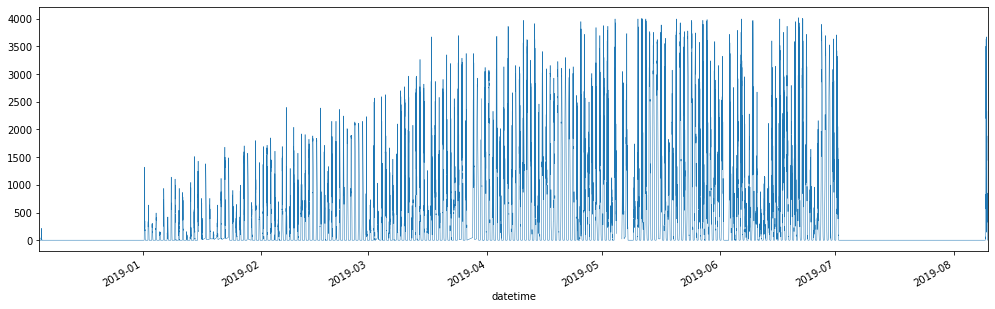

In [24]:
timeseries = get_data_from_hdf(hdf_key(system_id))
timeseries['instantaneous_power_gen_W'].plot(figsize=(17, 5), linewidth=0.5);

In [25]:
timeseries['instantaneous_power_gen_W'].isnull().sum()

55

In [26]:
timeseries.index.duplicated().sum()

0

In [27]:
timeseries.head()

,cumulative_energy_gen_Wh,energy_efficiency_kWh_per_kW,instantaneous_power_gen_W,average_power_gen_W,power_gen_normalised,energy_consumption_Wh,power_demand_W,temperature_C,voltage,datetime_of_API_request,query_date
datetime,,,,,,,,,,,
2018-12-05 00:05:00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,10.8,NaN,NaT,NaT
2018-12-05 00:10:00,0.0,0.0,0.0,0.0,0.0,NaN,NaN,10.5,NaN,NaT,NaT
2018-12-05 00:15:00,0.0,0.0,0.0,0.0,0.0,NaN,NaN,11.0,NaN,NaT,NaT
2018-12-05 00:20:00,0.0,0.0,0.0,0.0,0.0,NaN,NaN,11.2,NaN,NaT,NaT
2018-12-05 00:25:00,0.0,0.0,0.0,0.0,0.0,NaN,NaN,11.4,NaN,NaT,NaT


In [28]:
pv_systems_filtered.loc[system_id]

Array Tilt                                    30.0°
Inverter                                 SMA 4000TL
Location                         United Kingdom NG9
Orientation                              East 90.0°
Panels                     20x190W Schuco 190 MS 05
Shade                                            No
system_name                            The Bowler's
Outputs                          2894 days 00:00:00
Generation                                32.299MWh
Average                                   11.161kWh
Efficiency                              3.086kWh/kW
system_capacity_kw                              3.8
efficiency_kWh_per_kW                         3.086
system_1_tilt_degrees                            30
system_2_tilt_degrees                           NaN
system_capacity_kW                              3.8
status_interval_minutes                          10
install_date                    2011-08-12 00:00:00
latitude                                    52.9485
longitude   

## Tidy up HDF file

In [22]:
# The HDF compression seems to break if we keep appending data,
# so we get much smaller files if we create a new HDF file with
# the same data.

store = pd.HDFStore(OUTPUT_TIMESERIES_FILENAME, mode='r')
store2 = pd.HDFStore(OUTPUT_TIMESERIES_FILENAME + '.fresh', mode='w', complevel=9)

keys = store.keys()
n = len(keys)
for i, key in enumerate(keys):
    print('\r', key, i+1, 'of', n, end='   ', flush=True)
    data = store.get(key)
#     data['datetime_of_API_request'] = pd.DatetimeIndex(data['datetime_of_API_request'].values, tz='utc')
    data.rename(
        {
            'energy_generation_Wh': 'cumulative_energy_gen_Wh',
            'power_generation_W' : 'instantaneous_power_gen_W',
            'average_power_W': 'average_power_gen_W',
            'power_generation_normalised': 'power_gen_normalised',
        }, 
        axis='columns', 
        inplace=True)
    
    if key != '/missing_dates':
        data = data.sort_index()
        data = data.loc[~data.index.duplicated()]
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', tables.NaturalNameWarning) 
        store2.put(key=key, value=data, format='table')
        
store.close()
store2.close()

 /timeseries/9860 750 of 750    